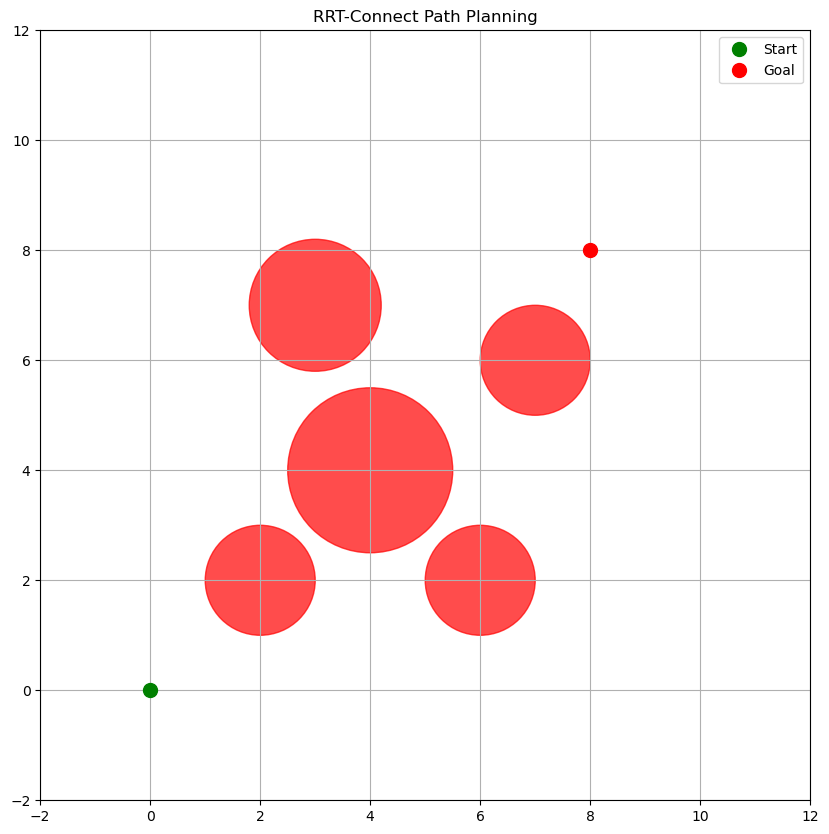

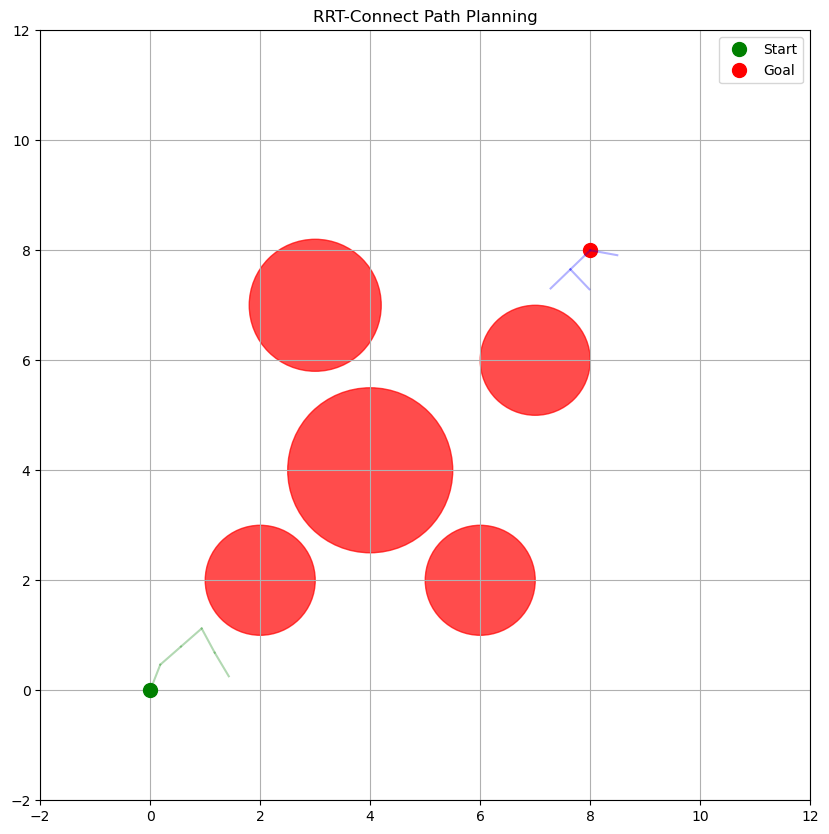

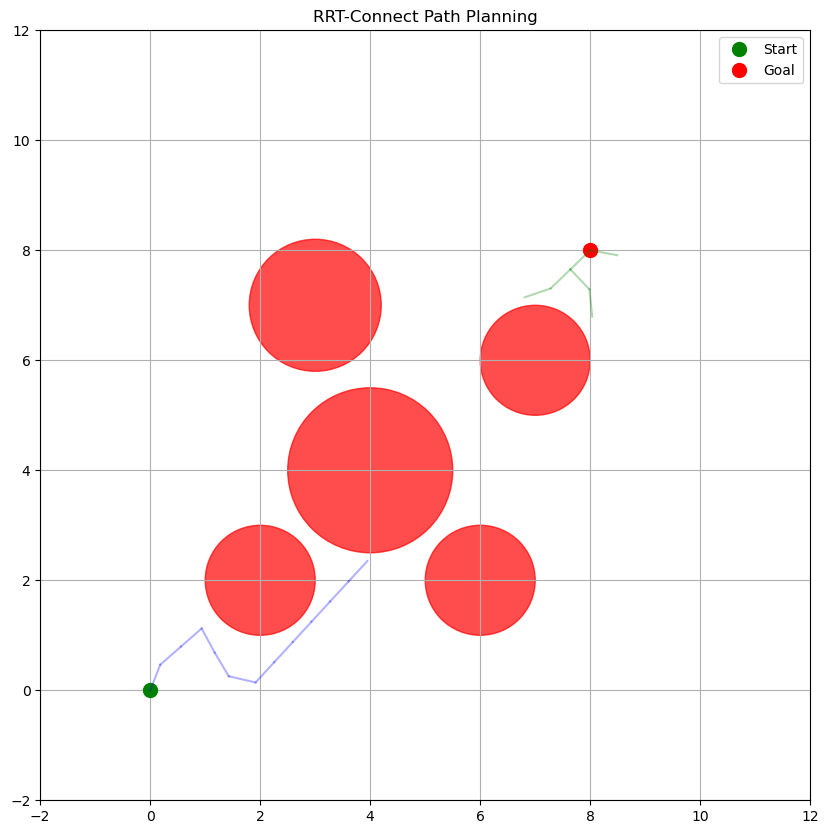

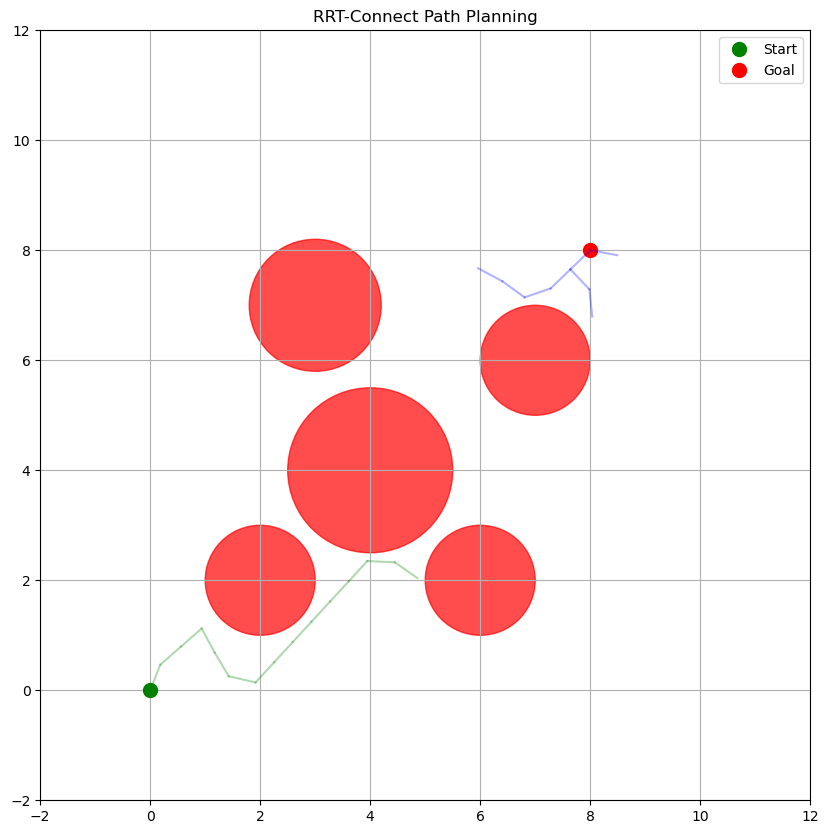

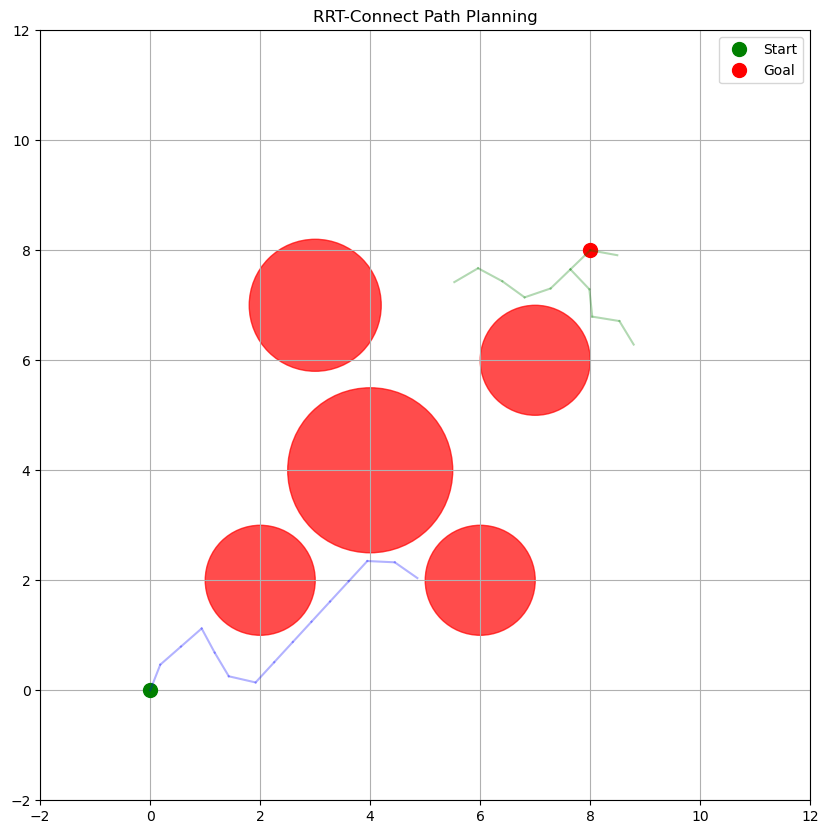

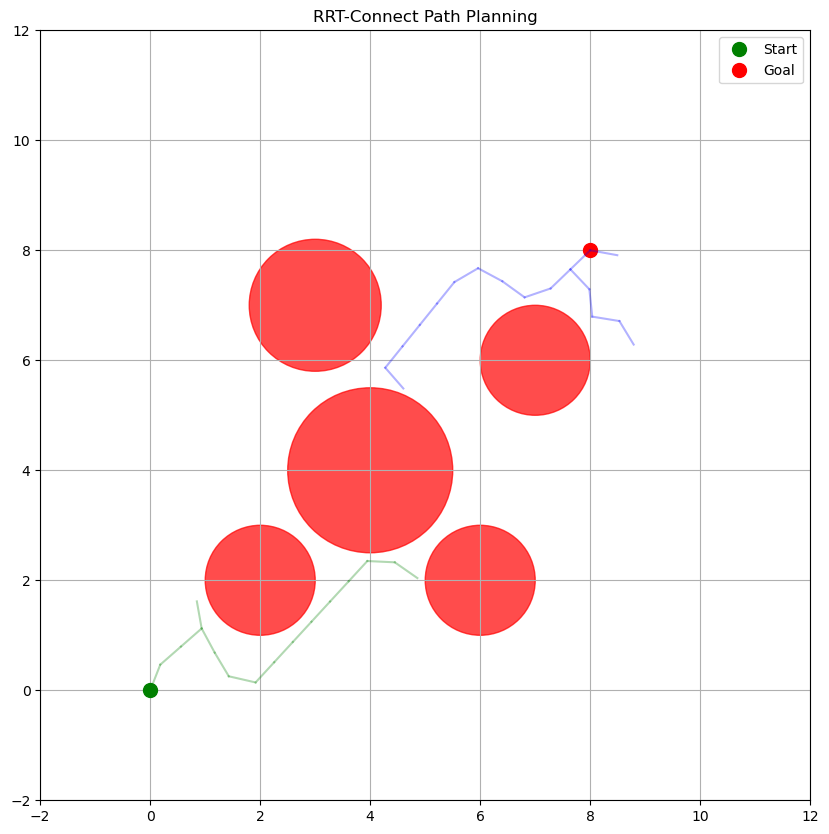

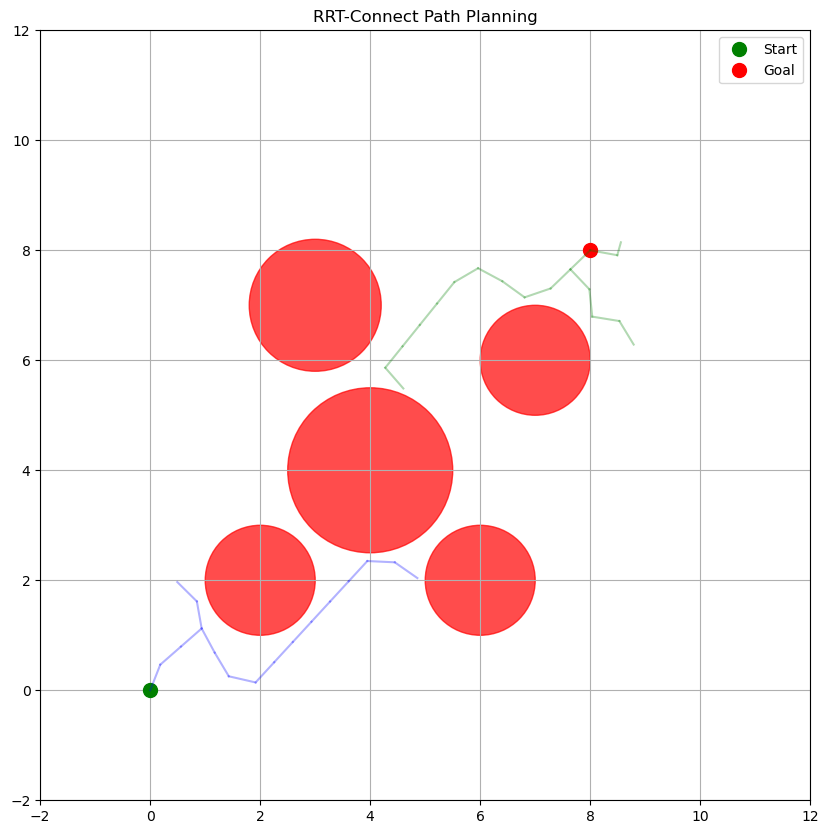

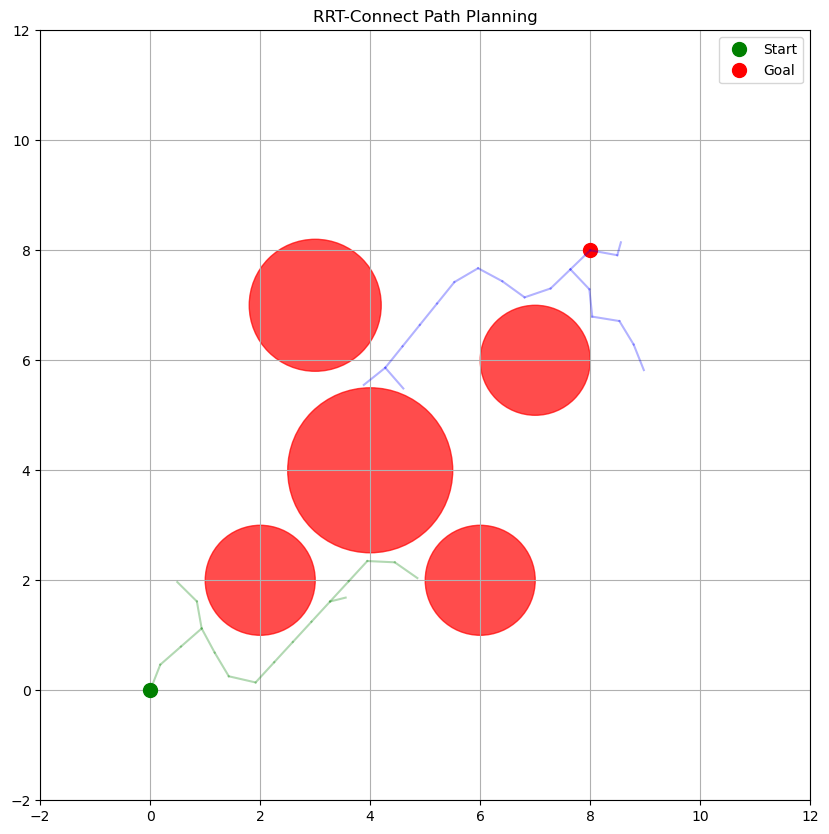

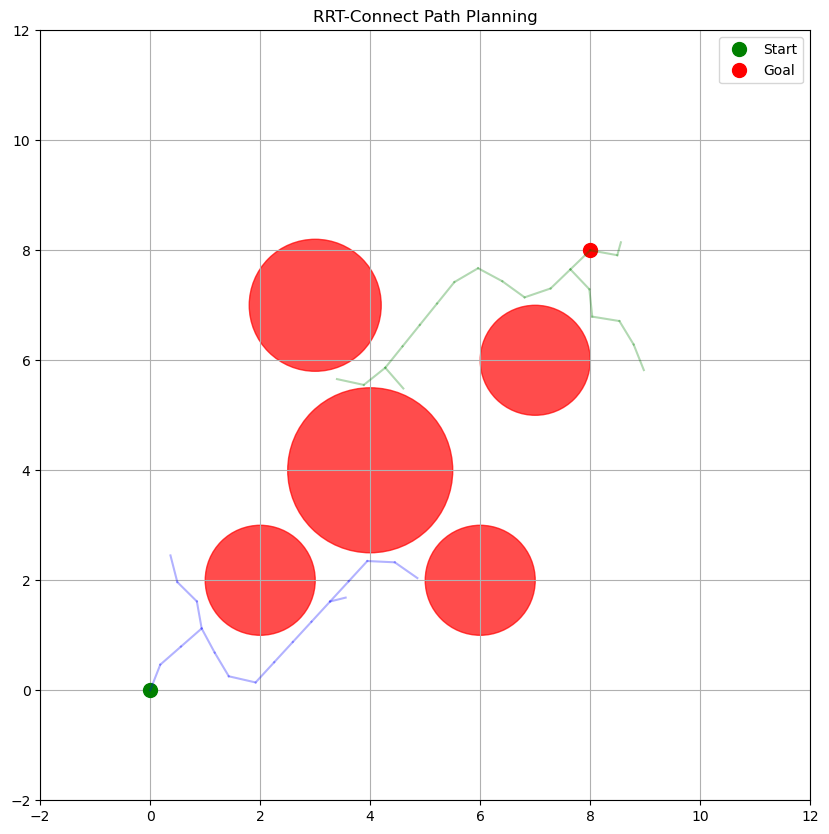

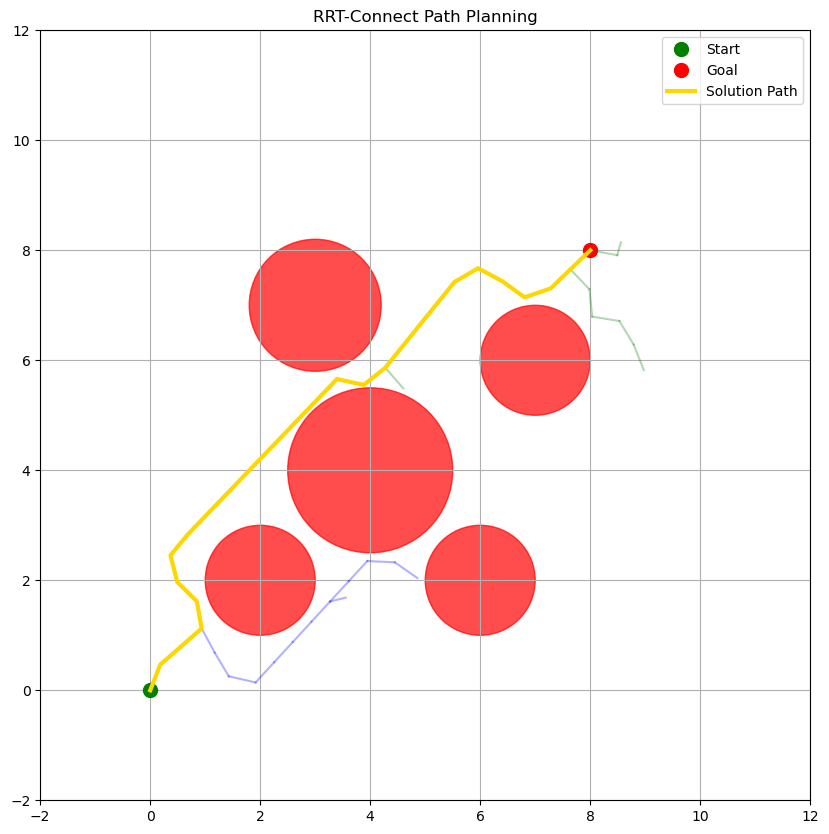

Path found after 40 iterations!
Path: [(0, 0), (0.182638594499129, 0.4654493998270733), (0.5589610223521223, 0.7946627505509294), (0.9352834502051156, 1.1238761012747855), (0.8478467012335622, 1.6161715561890937), (0.49227381940753007, 1.9676938537890192), (0.3679235489521411, 2.4519840666135937), (0.6866147558784899, 2.837257884343046), (0.9709634199001188, 3.1334288412662437), (1.3172448892006206, 3.4941075681397393), (1.6635263585011222, 3.854786295013235), (2.009807827801624, 4.215465021886731), (2.356089297102126, 4.576143748760226), (2.7023707664026277, 4.936822475633722), (3.0486522357031296, 5.297501202507218), (3.3949337050036315, 5.658179929380713), (3.8835287350540657, 5.551996613318278), (4.273885910598303, 5.86444064910889), (4.587763010359605, 6.253646463872022), (4.9016401101209075, 6.6428522786351545), (5.21551720988221, 7.032058093398287), (5.529394309643512, 7.421263908161419), (5.961117048710306, 7.673484994854552), (6.40164732020562, 7.436983240323502), (6.806922444

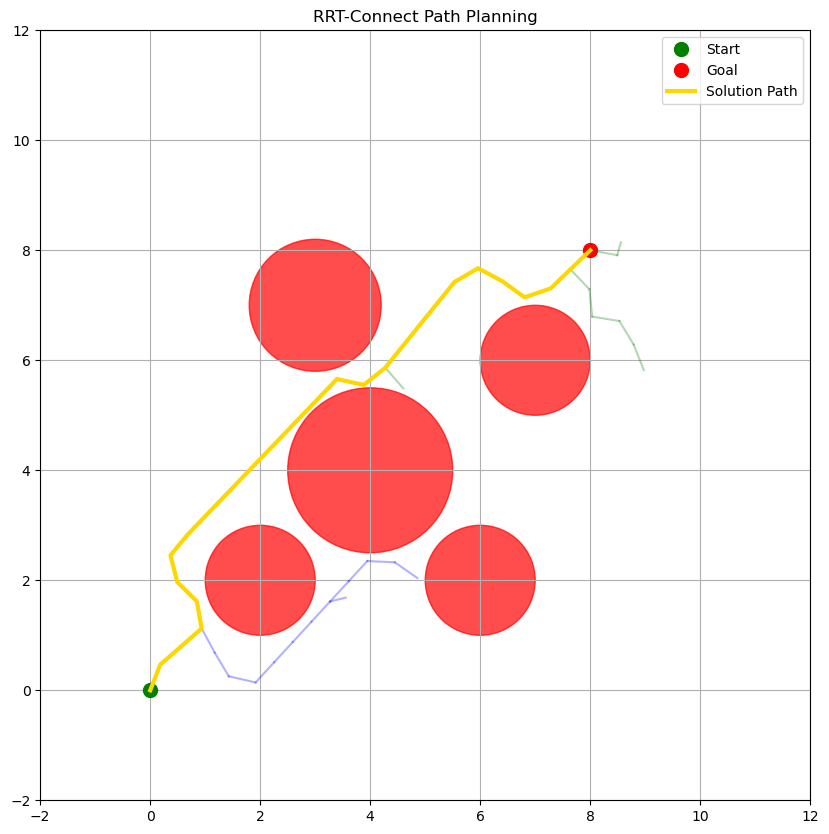

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import math
import random
from typing import List, Tuple, Optional
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

class Node:
    """Node class for RRT tree"""
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        self.parent = None
        self.children = []
        self.cost = 0.0

class Obstacle:
    """Circular obstacle class"""
    def __init__(self, x: float, y: float, radius: float):
        self.x = x
        self.y = y
        self.radius = radius
    
    def contains(self, point: Tuple[float, float]) -> bool:
        """Check if point is inside obstacle"""
        px, py = point
        distance = math.sqrt((px - self.x)**2 + (py - self.y)**2)
        return distance <= self.radius
    
    def plot(self, ax):
        """Plot the obstacle"""
        circle = plt.Circle((self.x, self.y), self.radius, color='red', alpha=0.7)
        ax.add_patch(circle)


class RRTConnect:
    def __init__(self, max_iters=1000):
        self.max_iters = int(max_iters)
        self.step_size = 0.5
        self.goal_threshold = 0.5
        self.goal_probability = 0.1  # Reduced for better exploration
        self.search_space = (-2, -2, 12, 12)  # x_min, y_min, x_max, y_max
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))

        # Two trees for RRT-Connect
        self.tree_a = []  # Start tree
        self.tree_b = []  # Goal tree
        self.obstacles = []
        self.path = []
        
        # Search space boundaries
        self.x_min = self.search_space[0]
        self.x_max = self.search_space[2]
        self.y_min = self.search_space[1]
        self.y_max = self.search_space[3]

    def plot_tree(self, start_pos, goal_pos, final_path=False, path=None):
        """Visualize the RRT-Connect trees"""
        self.ax.clear()
        
        # Set up the plot
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot start and goal
        self.ax.plot(start_pos[0], start_pos[1], 'go', markersize=10, label='Start')
        self.ax.plot(goal_pos[0], goal_pos[1], 'ro', markersize=10, label='Goal')
        
        # Plot obstacles
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot tree A (start tree) in blue
        for node in self.tree_a:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)
        
        # Plot tree B (goal tree) in green
        for node in self.tree_b:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'g-', alpha=0.3)
        
        # Plot the final path if requested
        if final_path and path:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            self.ax.plot(path_x, path_y, 'gold', linewidth=3, label='Solution Path')
        
        plt.title("RRT-Connect Path Planning")
        plt.legend()
        plt.draw()
        plt.pause(0.01)
    
    def build_path(self, node_a: Node, node_b: Node) -> List[Tuple[float, float]]:
        """Build the complete path from start to goal through both trees"""
        path_a = []  # From node_a to start
        path_b = []  # From node_b to goal
        
        # Build path from node_a to start (reverse order)
        current = node_a
        while current is not None:
            path_a.append((current.x, current.y))
            current = current.parent
        path_a.reverse()  # Now it's start to connection point
        
        # Build path from node_b to goal
        current = node_b
        while current is not None:
            path_b.append((current.x, current.y))
            current = current.parent
        
        return path_a + path_b
    
    def add_obstacle(self, obstacle: Obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
        
    def collision_free(self, from_x: float, from_y: float, to_x: float, to_y: float) -> bool:
        """Check if path between points is collision-free"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(from_x, from_y, to_x, to_y, obstacle):
                return False
        return True
    
    def line_intersects_obstacle(self, from_x: float, from_y: float, to_x: float, to_y: float, obstacle: Obstacle) -> bool:
        """Check if line segment intersects obstacle"""
        steps = 20
        for i in range(steps + 1):
            t = i / steps
            x = from_x + t * (to_x - from_x)
            y = from_y + t * (to_y - from_y)
            if obstacle.contains((x, y)):
                return True
        return False
        
    def euclid_distance(self, x1: float, x2: float, y1: float, y2: float) -> float:
        """Calculate Euclidean distance between two points"""
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def sample(self, goal_node: Node = None, use_goal_bias: bool = True) -> Tuple[float, float]:
        """Sample a random point in the search space"""
        # Goal biasing
        if use_goal_bias and goal_node and random.random() < self.goal_probability:
            return goal_node.x, goal_node.y
        
        # Random sampling
        x = random.uniform(self.x_min, self.x_max)
        y = random.uniform(self.y_min, self.y_max)
        return (x, y)

    def nearest_neighbor(self, tree: List[Node], point: Tuple[float, float]) -> Node:
        """Find the nearest node in the tree to the given point"""
        x, y = point
        min_distance = float('inf')
        nearest_node = None
        
        for node in tree:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance < min_distance:
                min_distance = distance
                nearest_node = node
        
        return nearest_node

    def steer(self, from_x: float, from_y: float, to_x: float, to_y: float) -> Tuple[float, float]:
        """Steer from current position towards target position"""
        dx = to_x - from_x
        dy = to_y - from_y
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            return (to_x, to_y)
        
        # Normalize and scale
        scale = self.step_size / distance
        new_x = from_x + dx * scale
        new_y = from_y + dy * scale
        
        return (new_x, new_y)
    
    def extend(self, tree: List[Node], target_point: Tuple[float, float]) -> Tuple[Optional[Node], bool]:
        """Extend tree towards target point"""
        nearest = self.nearest_neighbor(tree, target_point)
        new_point = self.steer(nearest.x, nearest.y, target_point[0], target_point[1])
        
        # Check collision
        if not self.collision_free(nearest.x, nearest.y, new_point[0], new_point[1]):
            return None, False
        
        # Create new node
        new_node = Node(new_point[0], new_point[1])
        new_node.parent = nearest
        new_node.cost = nearest.cost + self.euclid_distance(new_point[0], nearest.x, new_point[1], nearest.y)
        tree.append(new_node)
        nearest.children.append(new_node)
        
        # Check if we reached the target
        reached = (abs(new_point[0] - target_point[0]) < 1e-5 and 
                  abs(new_point[1] - target_point[1]) < 1e-5)
        
        return new_node, reached
    
    def connect(self, tree: List[Node], target_point: Tuple[float, float]) -> bool:
        """Keep extending tree towards target until collision or reached"""
        while True:
            new_node, reached = self.extend(tree, target_point)
            if not new_node:  # Collision
                return False
            if reached:  # Reached target
                return True
            if self.euclid_distance(new_node.x, target_point[0], new_node.y, target_point[1]) < self.step_size:
                return True
                
    def run_rrt_connect(self, start_position: List[float], goal_position: List[float]) -> Tuple[bool, int, List[Tuple[float, float]]]:
        """Run the RRT-Connect algorithm"""
        # Initialize trees
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        
        self.tree_a = [start_node]  # Start tree
        self.tree_b = [goal_node]   # Goal tree
        
        path_found = False
        iterations = self.max_iters
        
        for i in range(self.max_iters):
            # Visualize every 50 iterations
            if i % 5 == 0:
                self.plot_tree(start_position, goal_position)
            
            # Sample random point
            rand_point = self.sample(goal_node)
            
            # Extend tree A towards random point
            new_node_a, reached_a = self.extend(self.tree_a, rand_point)
            
            if new_node_a:
                # Try to connect tree B to the new node
                if self.connect(self.tree_b, (new_node_a.x, new_node_a.y)):
                    # Path found!
                    connecting_node_b = self.nearest_neighbor(self.tree_b, (new_node_a.x, new_node_a.y))
                    self.path = self.build_path(new_node_a, connecting_node_b)
                    path_found = True
                    iterations = i
                    break
            
            # Swap trees for balanced growth
            self.tree_a, self.tree_b = self.tree_b, self.tree_a
        
        # Final visualization
        self.plot_tree(start_position, goal_position, final_path=path_found, path=self.path if path_found else None)
        
        if path_found:
            print(f"Path found after {iterations} iterations!")
            print(f"Path: {self.path}")
        else:
            print("Failed to find path within maximum iterations")
        
        return path_found, iterations, self.path if path_found else []

# Example usage
def example_rrt_connect():
    """Example usage of RRT-Connect"""
    planner = RRTConnect(max_iters=2000)
    
    # Add obstacles
    planner.add_obstacle(Obstacle(2, 2, 1.0))
    planner.add_obstacle(Obstacle(4, 4, 1.5))
    planner.add_obstacle(Obstacle(6, 2, 1.0))
    planner.add_obstacle(Obstacle(3, 7, 1.2))
    planner.add_obstacle(Obstacle(7, 6, 1.0))
    
    # Define start and goal
    start_pos = [0, 0]
    goal_pos = [8, 8]
    
    # Run RRT-Connect
    success, iterations, path = planner.run_rrt_connect(start_pos, goal_pos)
    
    if success:
        print(f"Success! Path length: {len(path)} points")
        print(f"Path cost: {sum(planner.euclid_distance(path[i][0], path[i+1][0], path[i][1], path[i+1][1]) for i in range(len(path)-1)):.2f}")
    
    plt.show()
    return success, path

if __name__ == "__main__":
    example_rrt_connect()

Starting RRT-Connect...


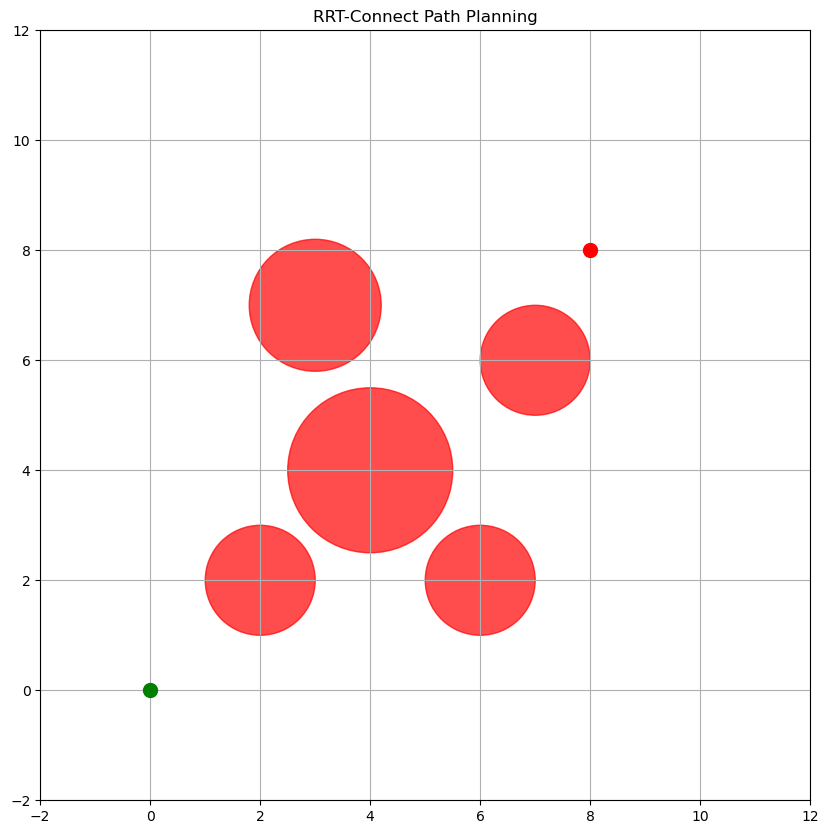

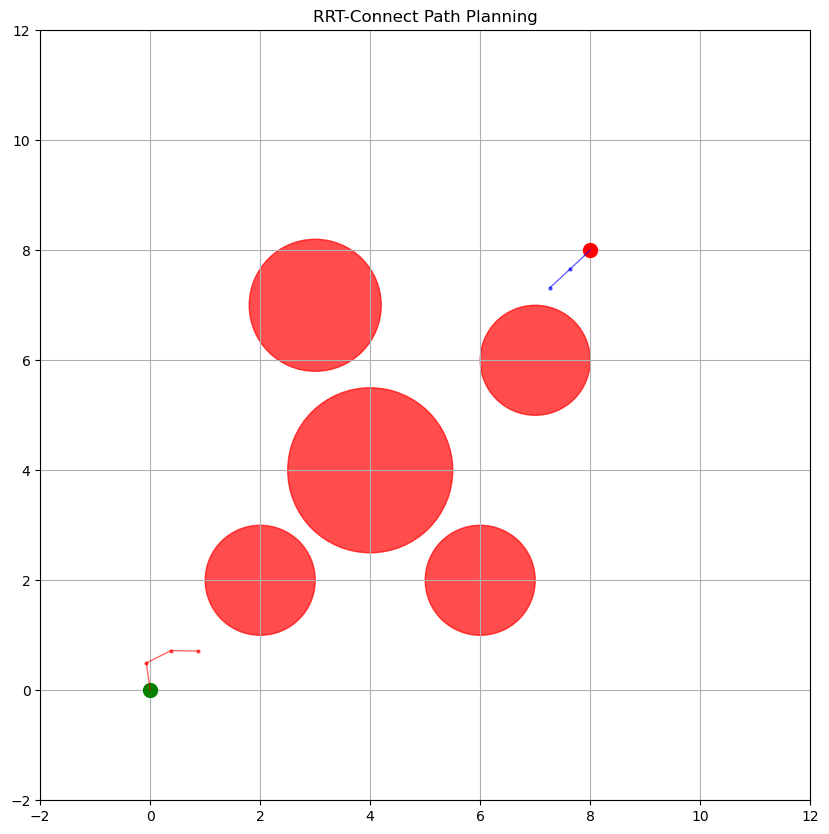

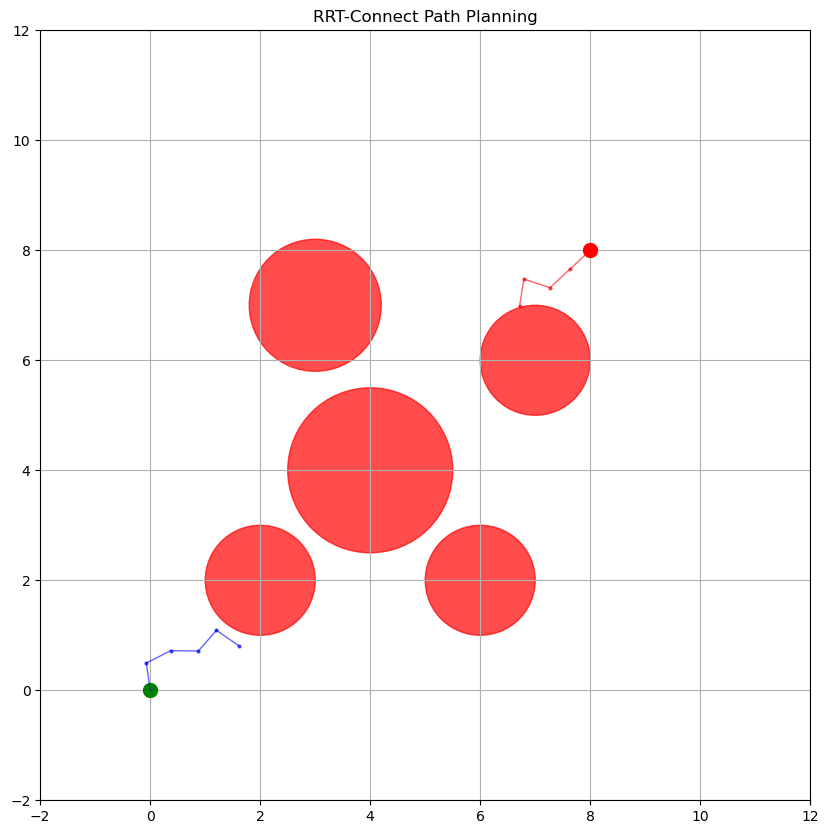

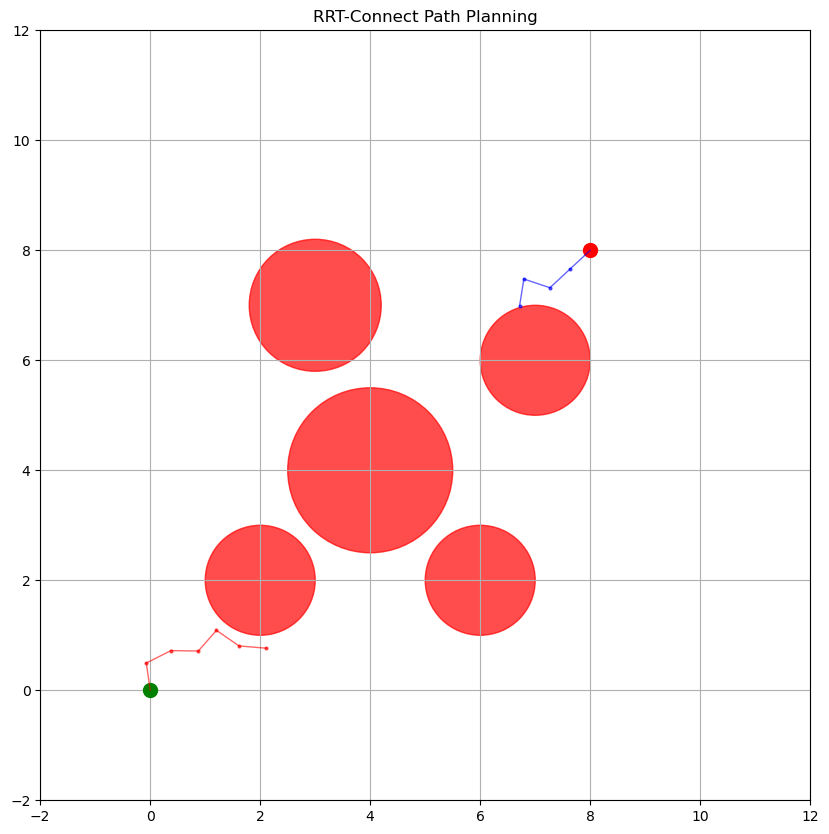

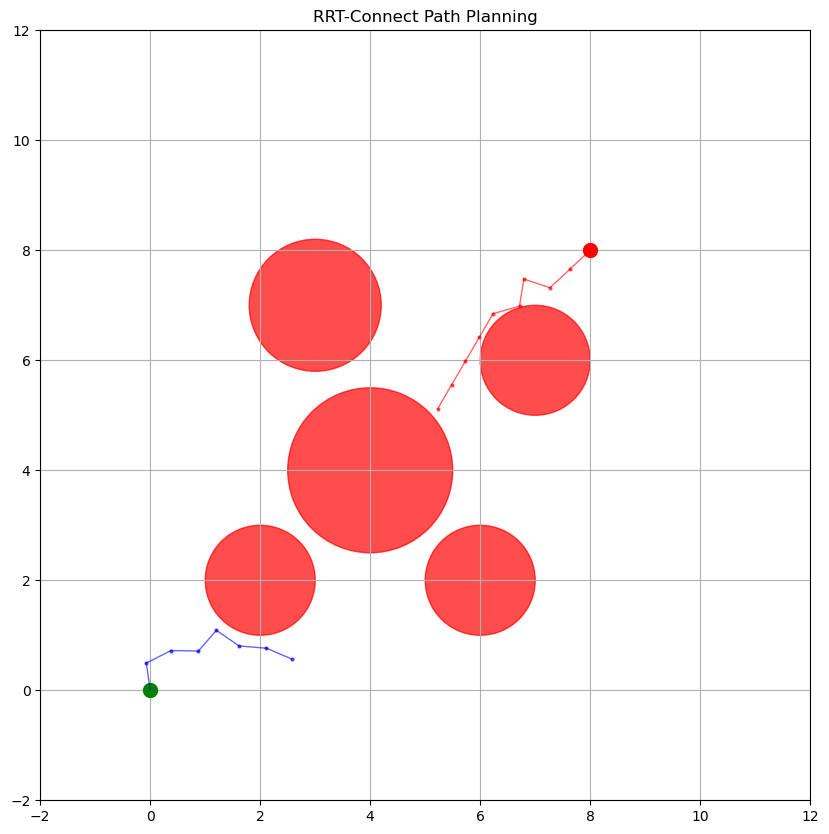

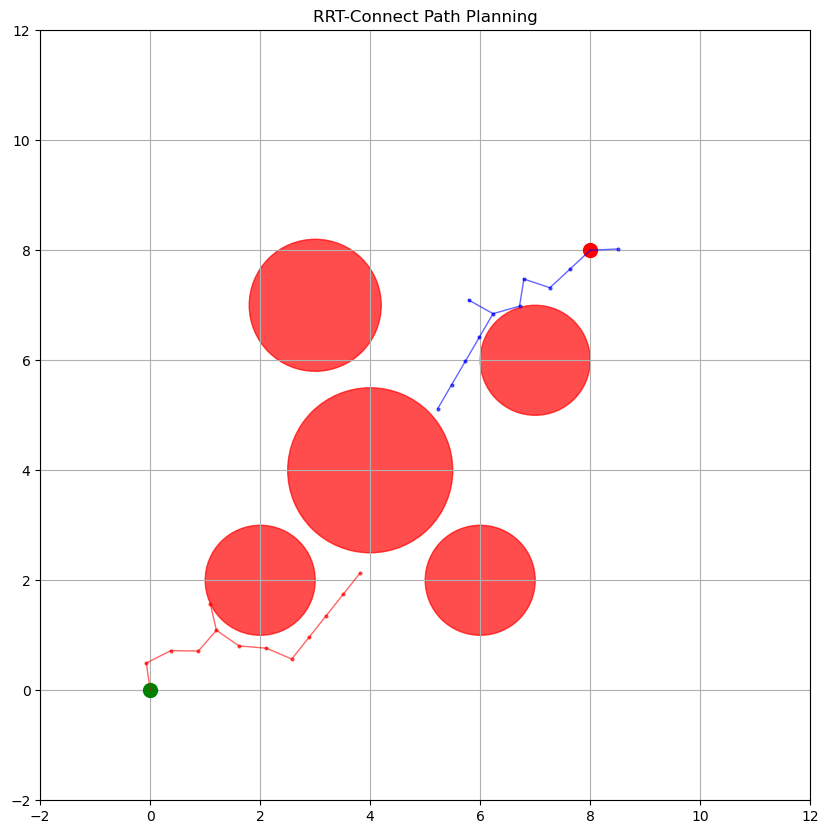

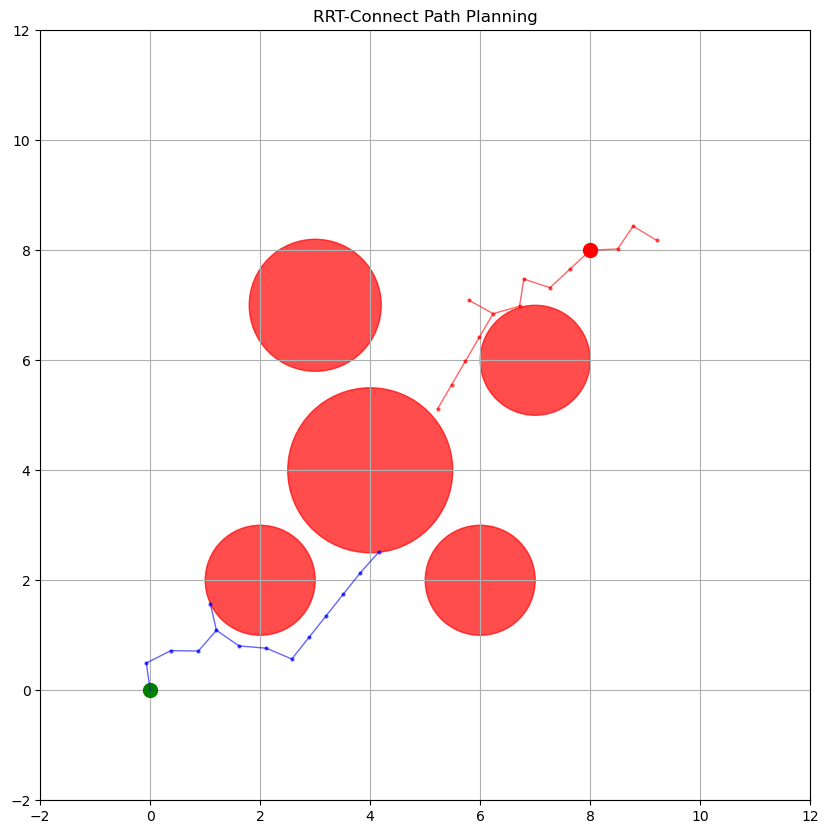

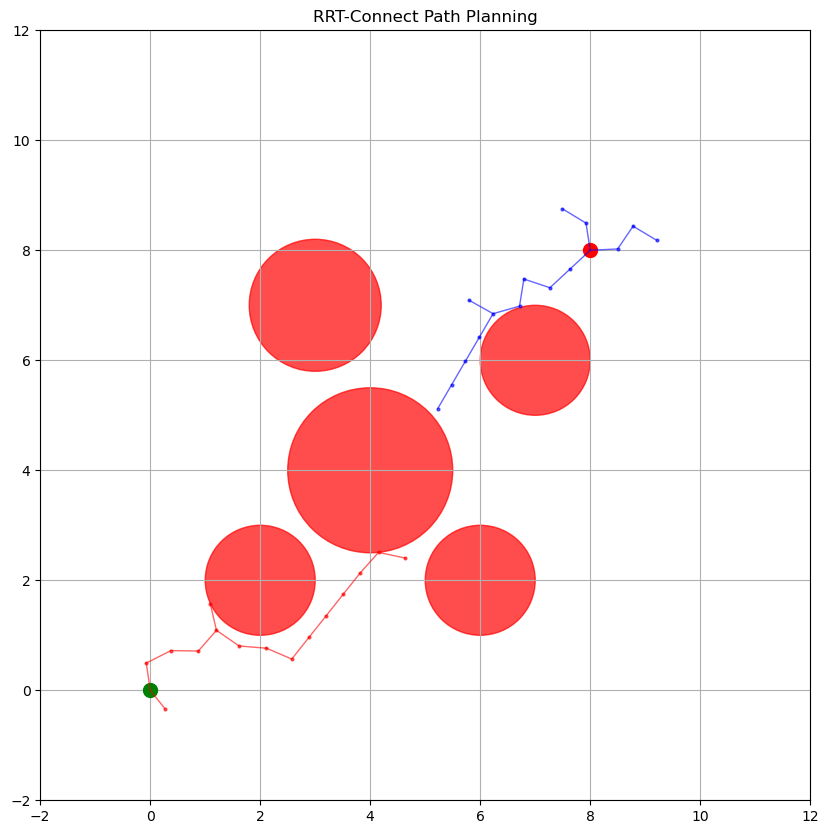

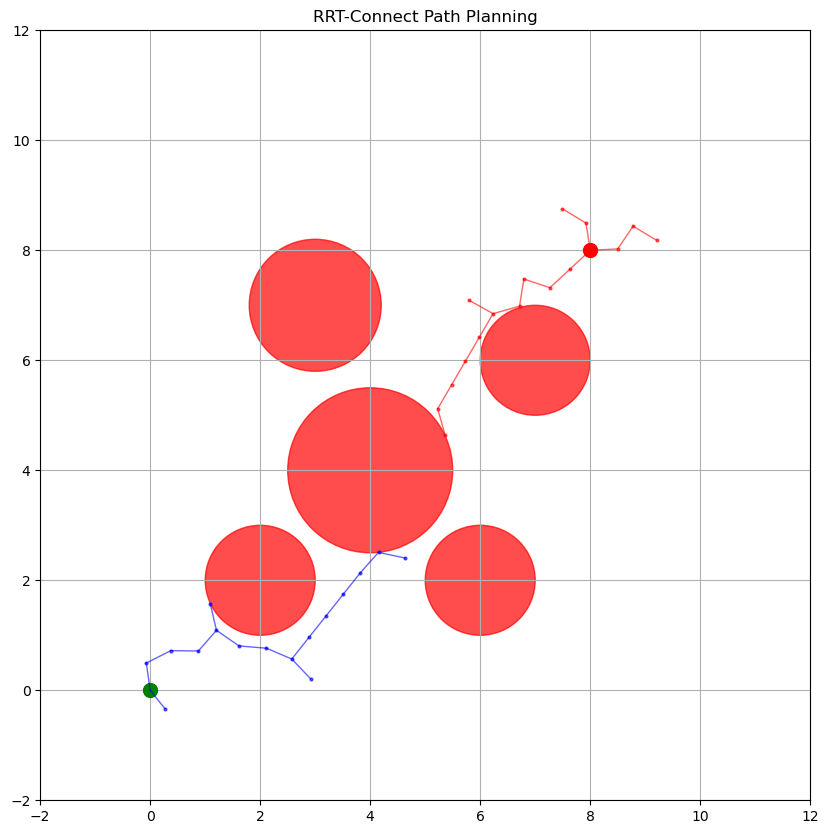

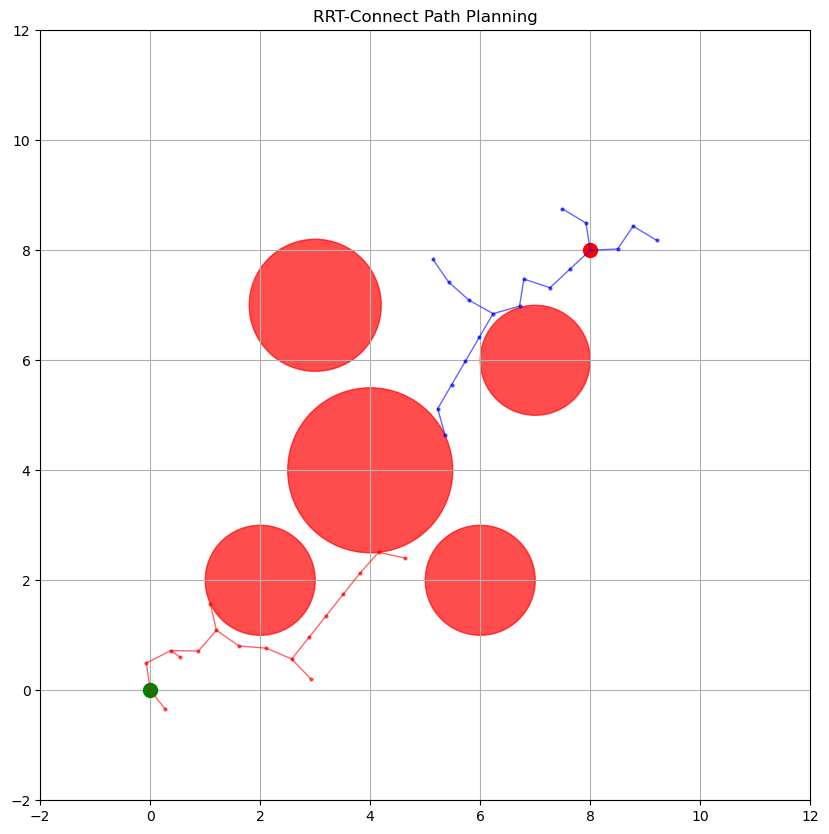

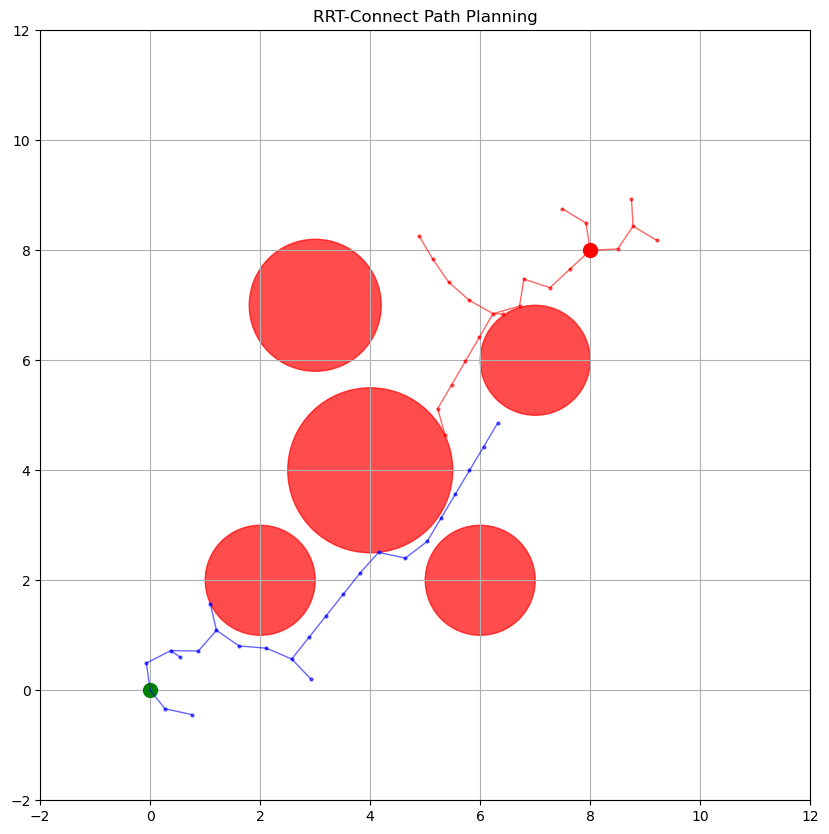

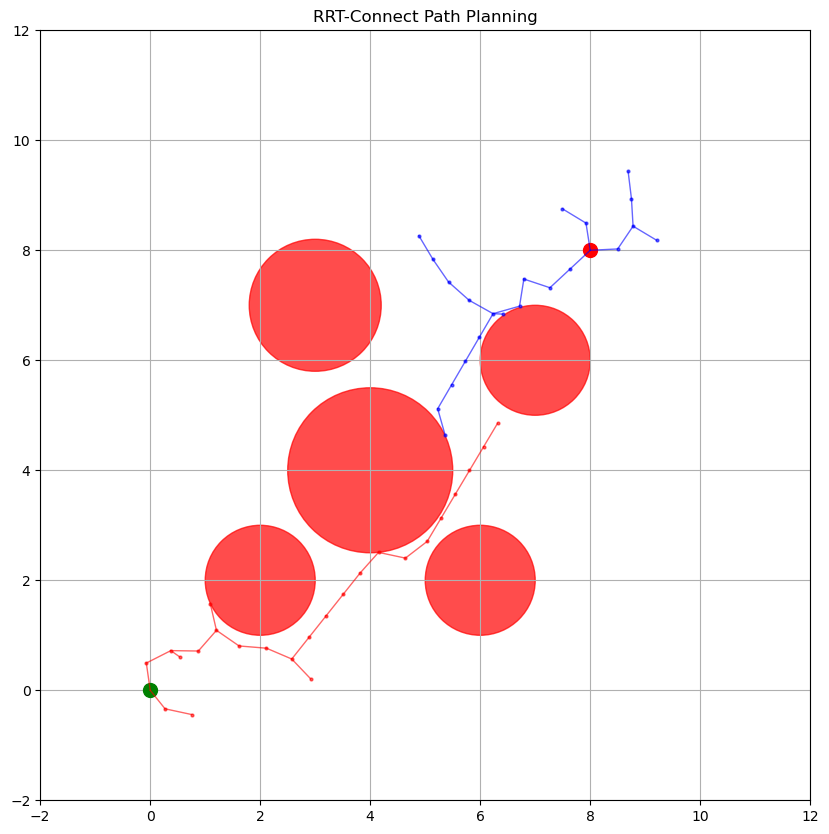

Trees connected at iteration 57!


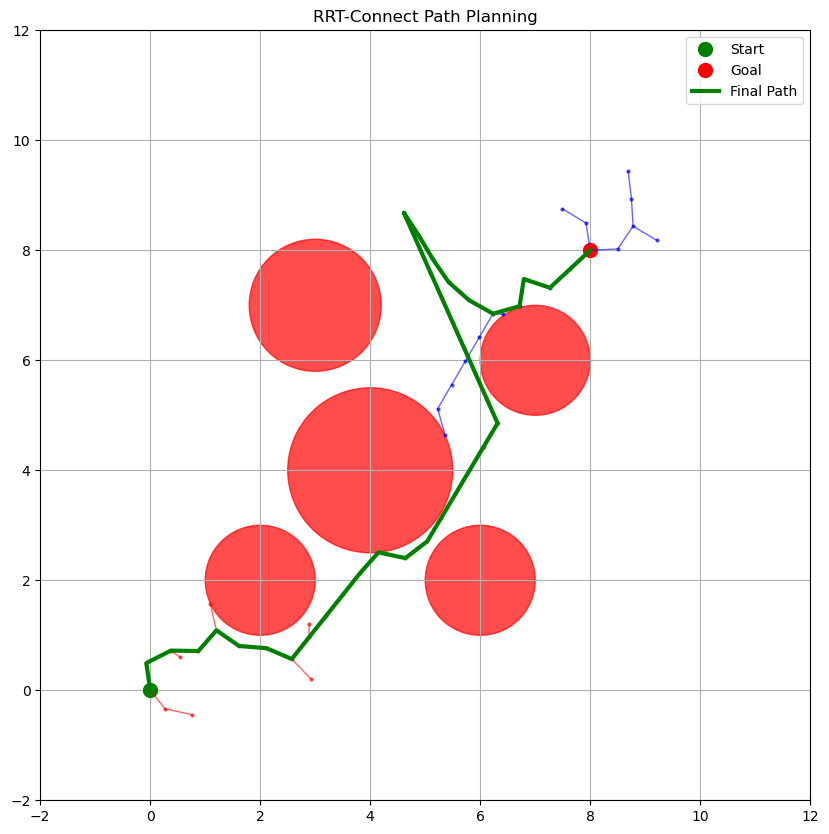

Path found: True
Path length: 39
Iterations: 57
Success! Path length: 39 points
Path cost: 18.69


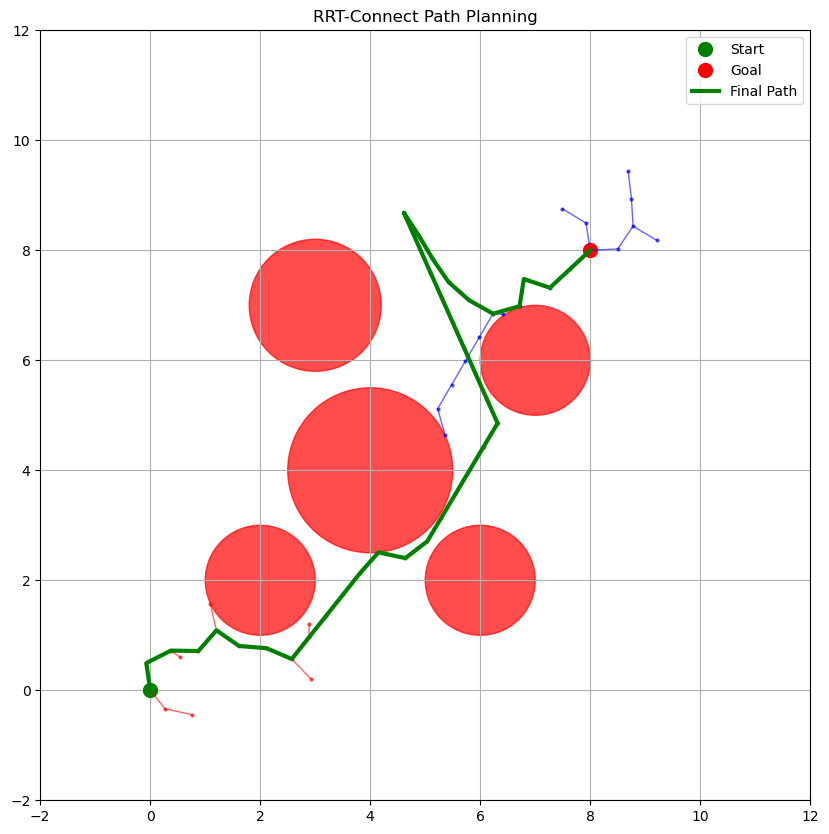

In [19]:
import math
import random
import matplotlib.pyplot as plt

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.children = []
        self.cost = 0.0

class RRTConnect:
    def __init__(self, max_iters=1000, step_size=0.5, goal_threshold=0.5):
        self.max_iters = int(max_iters)
        self.step_size = step_size
        self.goal_threshold = goal_threshold
        
        # Search space boundaries (x_min, y_min, x_max, y_max)
        self.search_space = (-2, -2, 12, 12)
        
        # Initialize plot
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        
        # Trees
        self.start_tree = []
        self.goal_tree = []
        self.obstacles = []
        self.path = []
        
        # Search space boundaries for convenience
        self.x_min = self.search_space[0]
        self.y_min = self.search_space[1]
        self.x_max = self.search_space[2]
        self.y_max = self.search_space[3]

    def plot_tree(self, start_pos, goal_pos, final_path=False, path=None):
        """Visualize both RRT trees"""
        self.ax.clear()

        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        self.ax.plot(start_pos[0], start_pos[1], 'go', markersize=10, label='Start')
        self.ax.plot(goal_pos[0], goal_pos[1], 'ro', markersize=10, label='Goal')
        
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot start tree (blue)
        for node in self.start_tree:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.6, linewidth=1)
                self.ax.plot(node.x, node.y, 'bo', markersize=2, alpha=0.6)
        
        # Plot goal tree (red)
        for node in self.goal_tree:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'r-', alpha=0.6, linewidth=1)
                self.ax.plot(node.x, node.y, 'ro', markersize=2, alpha=0.6)
        
        if final_path and path:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=3, label='Final Path')
            self.ax.legend()
        
        plt.title("RRT-Connect Path Planning")
        plt.draw()
        plt.pause(0.01)

    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)

    def collision_free(self, from_node, to_node):
        """Check if path between nodes is collision-free"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(from_node, to_node, obstacle):
                return False
        return True

    def line_intersects_obstacle(self, from_node, to_node, obstacle):
        """Check if line segment intersects obstacle"""
        # Sample points along the line segment
        steps = max(2, int(self.euclid_distance(from_node.x, to_node.x, from_node.y, to_node.y) / 0.1))
        for i in range(steps + 1):
            t = i / steps
            x = from_node.x + t * (to_node.x - from_node.x)
            y = from_node.y + t * (to_node.y - from_node.y)
            if obstacle.contains((x, y)):
                return True
        return False

    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def distance_between_nodes(self, node1, node2):
        return self.euclid_distance(node1.x, node2.x, node1.y, node2.y)

    def sample(self):
        """Sample a random point in the search space"""
        x = random.uniform(self.x_min, self.x_max)
        y = random.uniform(self.y_min, self.y_max)
        return (x, y)

    def nearest_neighbor(self, point, tree):
        """Find the nearest node in the tree to the given point"""
        x, y = point
        min_distance = float('inf')
        nearest_node = None
        for node in tree:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance < min_distance:
                min_distance = distance
                nearest_node = node
        return nearest_node

    def steer(self, from_node, to_point):
        """Steer from current node towards target point"""
        dx = to_point[0] - from_node.x
        dy = to_point[1] - from_node.y
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            return Node(to_point[0], to_point[1])
        
        scale = self.step_size / distance
        new_x = from_node.x + dx * scale
        new_y = from_node.y + dy * scale
        
        return Node(new_x, new_y)

    def extend(self, tree, target_point):
        """
        Extend the tree towards the target point
        Returns: (new_node, status) where status is:
        - "trapped": no extension due to collision
        - "advanced": extended but didn't reach target
        - "reached": extended and reached target exactly
        """
        nearest = self.nearest_neighbor(target_point, tree)
        new_node = self.steer(nearest, target_point)
        
        if self.collision_free(nearest, new_node):
            new_node.parent = nearest
            new_node.cost = nearest.cost + self.distance_between_nodes(nearest, new_node)
            tree.append(new_node)
            nearest.children.append(new_node)
            
            # Check if we reached the target point exactly
            distance_to_target = self.euclid_distance(new_node.x, target_point[0], new_node.y, target_point[1])
            if distance_to_target <= 1e-5:
                return new_node, "reached"
            else:
                return new_node, "advanced"
        
        return nearest, "trapped"

    def connect(self, tree, target_point):
        """
        Connect phase: repeatedly extend tree towards target point
        Returns when trapped or reached
        """
        while True:
            new_node, status = self.extend(tree, target_point)
            if status != "advanced":  # Either trapped or reached
                return new_node, status

    def trees_connected(self, node_a, node_b):
        """Check if two nodes from different trees can connect"""
        if self.distance_between_nodes(node_a, node_b) <= self.goal_threshold:
            return self.collision_free(node_a, node_b)
        return False

    def build_path(self, connect_node_a, connect_node_b):
        """Build the path from start to goal through the connection point"""
        # Build path from connect_node_a to start (reverse)
        path_from_start = []
        node = connect_node_a
        while node is not None:
            path_from_start.append((node.x, node.y))
            node = node.parent
        path_from_start = path_from_start[::-1]  # Reverse to get start-to-connection
        
        # Build path from connect_node_b to goal
        path_to_goal = []
        node = connect_node_b
        while node is not None:
            path_to_goal.append((node.x, node.y))
            node = node.parent
        
        # Combine paths (remove duplicate connection point)
        full_path = path_from_start + path_to_goal[1:]
        return full_path

    def run_rrt_connect(self, start_position, goal_position):
        """
        Original RRT-Connect algorithm as described in the paper:
        1. Extend one tree toward random configuration
        2. Try to connect other tree to new node  
        3. Swap trees and repeat
        """
        # Initialize trees
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        
        self.start_tree = [start_node]
        self.goal_tree = [goal_node]
        
        path_found = False
        iterations = 0
        final_path = []
        
        print("Starting RRT-Connect...")
        
        for i in range(self.max_iters):
            # Visualize every 50 iterations
            if i % 5 == 0:
                self.plot_tree(start_position, goal_position)
            
            # EXTEND PHASE: Extend Ta toward a random configuration
            random_point = self.sample()
            new_node, extend_status = self.extend(self.start_tree, random_point)
            
            if extend_status != "trapped":
                # CONNECT PHASE: Try to connect Tb to the new node
                # This is the key difference from basic RRT - we try to CONNECT, not just extend once
                connected_node, connect_status = self.connect(self.goal_tree, (new_node.x, new_node.y))
                
                # Check if trees are connected
                if self.trees_connected(new_node, connected_node):
                    print(f"Trees connected at iteration {i}!")
                    final_path = self.build_path(new_node, connected_node)
                    self.plot_tree(start_position, goal_position, final_path=True, path=final_path)
                    path_found = True
                    iterations = i
                    break
            
            # SWAP TREES: Swap the roles of Ta and Tb for next iteration
            # This ensures both trees grow toward each other
            self.start_tree, self.goal_tree = self.goal_tree, self.start_tree
        
        if not path_found:
            print("No path found within iteration limit")
            self.plot_tree(start_position, goal_position)
        
        print(f"Path found: {path_found}")
        print(f"Path length: {len(final_path) if path_found else 0}")
        print(f"Iterations: {iterations}")
        
        return path_found, iterations, final_path

    def calculate_path_length(self, path):
        """Calculate the total length of the path"""
        if len(path) < 2:
            return 0
        
        total_length = 0
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i + 1]
            total_length += self.euclid_distance(x1, x2, y1, y2)
        
        return total_length

# Example usage
def example_rrt_connect():
    """Example usage of RRT-Connect"""
    planner = RRTConnect(max_iters=2000)
    
    # Add obstacles
    planner.add_obstacle(Obstacle(2, 2, 1.0))
    planner.add_obstacle(Obstacle(4, 4, 1.5))
    planner.add_obstacle(Obstacle(6, 2, 1.0))
    planner.add_obstacle(Obstacle(3, 7, 1.2))
    planner.add_obstacle(Obstacle(7, 6, 1.0))
    
    # Define start and goal
    start_pos = [0, 0]
    goal_pos = [8, 8]
    
    # Run RRT-Connect
    success, iterations, path = planner.run_rrt_connect(start_pos, goal_pos)
    
    if success:
        print(f"Success! Path length: {len(path)} points")
        print(f"Path cost: {sum(planner.euclid_distance(path[i][0], path[i+1][0], path[i][1], path[i+1][1]) for i in range(len(path)-1)):.2f}")
    
    plt.show()
    return success, path

if __name__ == "__main__":
    example_rrt_connect()

In [1]:
#pseudocode for possible stuff
K = 10000
sub_iterations = 25
p_tree = []
s_tree = []
p_tree_active = True # if p_tree active, s_tree inactive, if p_tree inactive, s_tree active
connection_distance_threshold = 2
#might need to initialize new_node_a and new_node_b to start and goal
for k in ramge(0, K):
    if p_tree_active:
        sampled_point = goal
        if rrt.euclid_dist(prev_newest_node, new_node_b) < connection_distance_threshold:
            sampled_point = new_node_b
        new_node_a = rrt.sample_and_create_node(sampled_point)
        if new_node_a in obstacle: #maybe use a while loop to sample until no collision
            new_node_a = rrt.sample_and_create_node(random)
            # p_tree_active = False
        if (k % sub_iterations == 0 and rrt.euclid_dist(prev_newest_node, sampled_point) > connection_distance_threshold:
            p_tree_active = False
            
        p_tree.add_to_tree(new_node_a)

    else:
        new_node_b = rrt.sample_and_create_node(new_node_a)
        if new_node_b in obstacle: #maybe use a while loop to sample until no collision
            new_node_b = rrt.sample_and_create_node(random)

        if k % sub_iterations == 0:
            p_tree_active = True
            
        s_tree.add_to_tree(new_node_b)


SyntaxError: invalid syntax (2724471962.py, line 18)